In [1]:
import sklearn_crfsuite
from sklearn_crfsuite import scorers, CRF
from sklearn_crfsuite import metrics
from sklearn_crfsuite.metrics import flat_classification_report
import pandas as pd
import numpy as np
import imp, sys
sys.path.append('./src/')
import feature_utils
import seaborn as sns
import doc_utils_clean as doc_utils
import matplotlib.pyplot as plt
from matplotlib import rcParamsDefault
import defines

In [165]:
imp.reload(feature_utils)

<module 'feature_utils' from './src/feature_utils.py'>

In [3]:
take_columns = ['sent_len','first_sent_in_nar','last_sent_in_nar','is_client','is_nar']

In [37]:
imp.reload(doc_utils)
!pwd
sent_db = pd.read_csv("./dataframes/sent_db.csv",usecols=take_columns,nrows=301)

/scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis


In [38]:
sent_db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   is_nar             301 non-null    float64
 1   sent_len           301 non-null    float64
 2   first_sent_in_nar  301 non-null    bool   
 3   last_sent_in_nar   301 non-null    bool   
 4   is_client          301 non-null    int64  
dtypes: bool(2), float64(2), int64(1)
memory usage: 7.8 KB


In [39]:
sent_tokens_db = pd.read_csv("./dataframes/sent_tokens_db_1.0.csv")

In [40]:
sent_tokens_db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3138 entries, 0 to 3137
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   FROM       3138 non-null   int64  
 1   sent_idx   3138 non-null   float64
 2   TO         3138 non-null   int64  
 3   FORM       3138 non-null   object 
 4   LEMMA      3138 non-null   object 
 5   CPOSTAG    3138 non-null   object 
 6   POSTAG     3138 non-null   object 
 7   f_gen      1517 non-null   object 
 8   f_num      1517 non-null   object 
 9   FEATS      3138 non-null   object 
 10  TOKEN      3138 non-null   int64  
 11  f_suf_gen  33 non-null     object 
 12  f_suf_num  33 non-null     object 
 13  f_suf_per  33 non-null     float64
 14  f_per      816 non-null    object 
 15  f_tense    185 non-null    object 
dtypes: float64(2), int64(3), object(11)
memory usage: 392.4+ KB


In [41]:
columns_to_count = ['POSTAG','f_gen','f_num','f_suf_gen','f_suf_num','f_suf_per','f_per','f_tense']
sent_tokens_dummies =pd.get_dummies(sent_tokens_db,columns=columns_to_count)

In [42]:
sent_tokens_dummies

,FROM,sent_idx,TO,FORM,LEMMA,CPOSTAG,FEATS,TOKEN,POSTAG_ADVERB,POSTAG_AT,...,f_suf_per_2.0,f_suf_per_3.0,f_per_1,f_per_2,f_per_3,f_per_A,f_tense_BEINONI,f_tense_FUTURE,f_tense_IMPERATIVE,f_tense_PAST
0,0,0.000000,1,טוב,טוב,NNT,gen=M|num=S,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0.000000,2,אהלן,אהלן,INTJ,_,2,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0.000000,3,נ,נ,NNP,gen=F|gen=M|num=S,3,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1.000000,1,היי,הי,INTJ,_,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1.000000,2,מה,מה,QW,_,2,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3133,2,300.000000,3,סיפור,סיפור,NN,gen=M|num=S,3,0,0,...,0,0,0,0,0,0,0,0,0,0
3134,3,300.000000,4,ה,ה,DEF,_,4,0,0,...,0,0,0,0,0,0,0,0,0,0
3135,4,300.000000,5,זה,זה,PRP,gen=M|num=S|per=3,4,0,0,...,0,0,0,0,1,0,0,0,0,0
3136,5,300.000000,6,של,של,POS,_,5,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
sent_tokens_dummies.groupby('sent_idx')
sent_tokens_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3138 entries, 0 to 3137
Data columns (total 58 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   FROM                3138 non-null   int64  
 1   sent_idx            3138 non-null   float64
 2   TO                  3138 non-null   int64  
 3   FORM                3138 non-null   object 
 4   LEMMA               3138 non-null   object 
 5   CPOSTAG             3138 non-null   object 
 6   FEATS               3138 non-null   object 
 7   TOKEN               3138 non-null   int64  
 8   POSTAG_ADVERB       3138 non-null   uint8  
 9   POSTAG_AT           3138 non-null   uint8  
 10  POSTAG_BN           3138 non-null   uint8  
 11  POSTAG_BNT          3138 non-null   uint8  
 12  POSTAG_CC           3138 non-null   uint8  
 13  POSTAG_CD           3138 non-null   uint8  
 14  POSTAG_CDT          3138 non-null   uint8  
 15  POSTAG_CONJ         3138 non-null   uint8  
 16  POSTAG

In [44]:
count_db = sent_tokens_dummies.groupby('sent_idx').sum()

In [172]:
count_db

,FROM,TO,TOKEN,POSTAG_ADVERB,POSTAG_AT,POSTAG_BN,POSTAG_BNT,POSTAG_CC,POSTAG_CD,POSTAG_CDT,...,f_suf_per_2.0,f_suf_per_3.0,f_per_1,f_per_2,f_per_3,f_per_A,f_tense_BEINONI,f_tense_FUTURE,f_tense_IMPERATIVE,f_tense_PAST
sent_idx,,,,,,,,,,,,,,,,,,,,,
0.000000,3,6,6,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1.000000,6,10,9,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2.000000,3,6,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3.000000,3,6,5,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4.000000,136,153,147,0,0,0,0,1,0,0,...,0,0,0,0,2,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296.000000,6,10,6,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
297.000000,66,78,61,0,0,0,0,0,0,0,...,0,0,2,1,0,0,0,1,0,0
298.000000,21,28,24,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0


In [231]:
merged_sent_pos =  pd.merge(sent_db,count_db.iloc[:,3:],left_index=True,right_index=True,validate="one_to_one")
merged_sent_pos.describe()

,is_nar,sent_len,is_client,POSTAG_ADVERB,POSTAG_AT,POSTAG_BN,POSTAG_BNT,POSTAG_CC,POSTAG_CD,POSTAG_CDT,...,f_suf_per_2.0,f_suf_per_3.0,f_per_1,f_per_2,f_per_3,f_per_A,f_tense_BEINONI,f_tense_FUTURE,f_tense_IMPERATIVE,f_tense_PAST
count,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,...,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000,301.000000
mean,0.564784,35.235880,0.764120,0.006645,0.169435,0.368771,0.013289,0.338870,0.079734,0.009967,...,0.003322,0.089701,0.700997,0.215947,1.338870,0.455150,0.036545,0.059801,0.006645,0.511628
std,0.496611,31.197984,0.425255,0.081378,0.448549,0.716627,0.114700,0.729007,0.346826,0.099500,...,0.057639,0.358599,1.044174,0.685477,1.660758,0.805491,0.204923,0.276427,0.081378,0.892953
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,13.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,27.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,50.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,187.000000,1.000000,1.000000,3.000000,5.000000,1.000000,4.000000,3.000000,1.000000,...,1.000000,3.000000,6.000000,6.000000,9.000000,6.000000,2.000000,2.000000,1.000000,6.000000


In [234]:
merged_sent_pos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 301 entries, 0 to 300
Data columns (total 55 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   last_sent_in_nar    301 non-null    bool   
 1   first_sent_in_nar   301 non-null    bool   
 2   is_nar              301 non-null    float64
 3   sent_len            301 non-null    float64
 4   is_client           301 non-null    int64  
 5   POSTAG_ADVERB       301 non-null    uint8  
 6   POSTAG_AT           301 non-null    uint8  
 7   POSTAG_BN           301 non-null    uint8  
 8   POSTAG_BNT          301 non-null    uint8  
 9   POSTAG_CC           301 non-null    uint8  
 10  POSTAG_CD           301 non-null    uint8  
 11  POSTAG_CDT          301 non-null    uint8  
 12  POSTAG_CONJ         301 non-null    uint8  
 13  POSTAG_COP          301 non-null    uint8  
 14  POSTAG_DEF          301 non-null    uint8  
 15  POSTAG_DT           301 non-null    uint8  
 16  POSTAG_DTT   

In [233]:
col = merged_sent_pos.pop("first_sent_in_nar")
merged_sent_pos.insert(0, col.name, col)
col = merged_sent_pos.pop("last_sent_in_nar")
merged_sent_pos.insert(0, col.name, col)

In [83]:
# dim = int(np.sqrt(len(merged_sent_pos.columns[8:])))
# fig, axes = plt.subplots(dim, dim+1, figsize=(30,30))
# for i,col in enumerate(merged_sent_pos.columns[8:]):
#     ax = axes.ravel()[i]
#     merged_sent_pos.groupby('is_nar')[col].plot(ax=ax,legend=True,kind='kde')
# fig.tight_layout()
# plt.show()
# merged_sent_pos.groupby('is_nar').plot(legend=True,kind='density',subplots=True)

/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/seaborn/axisgrid.py:409: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)


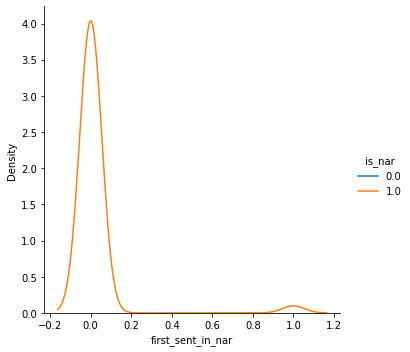

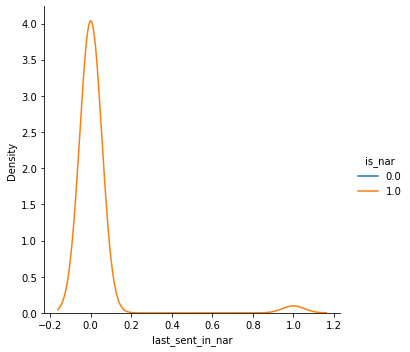

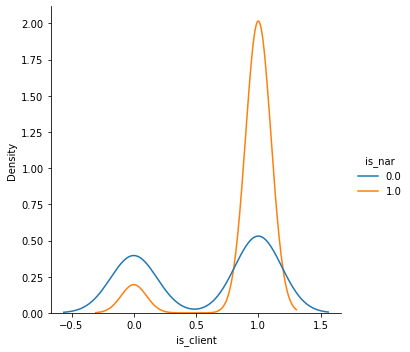

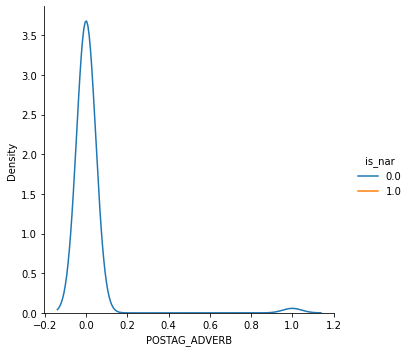

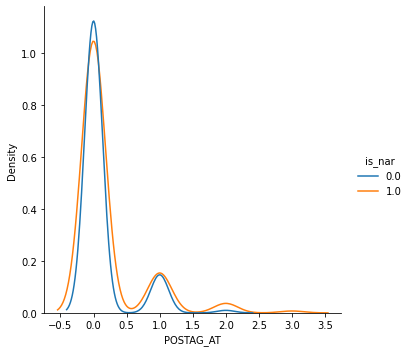

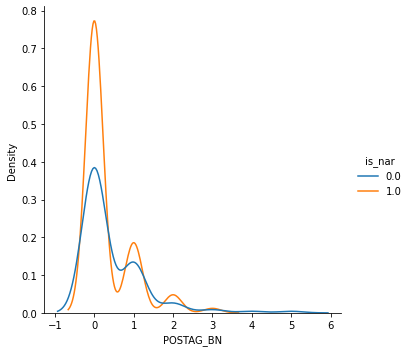

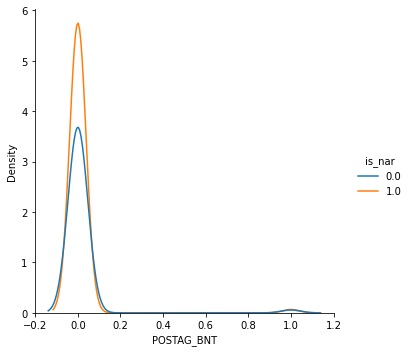

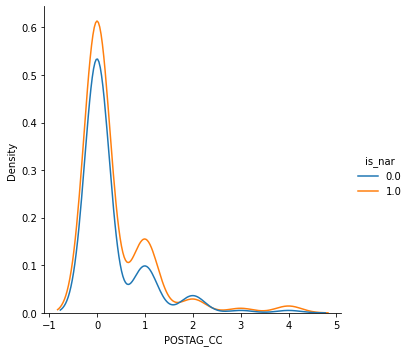

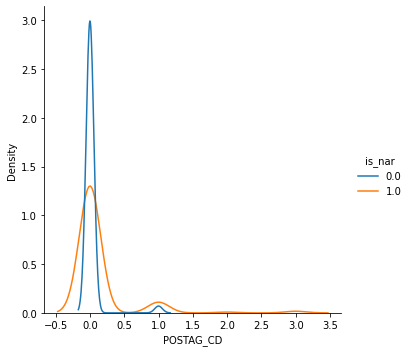

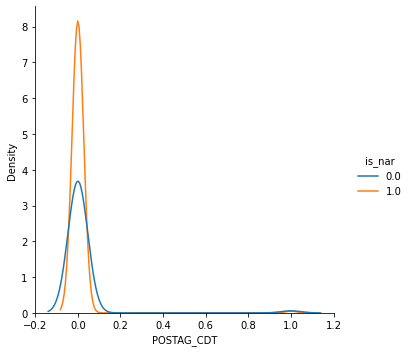

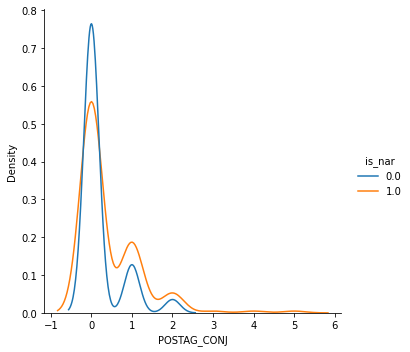

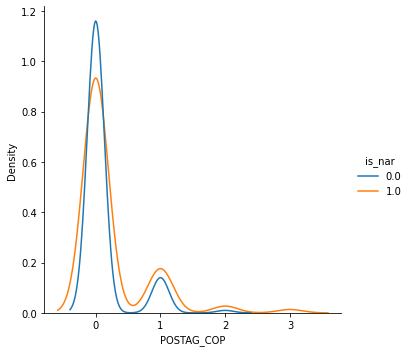

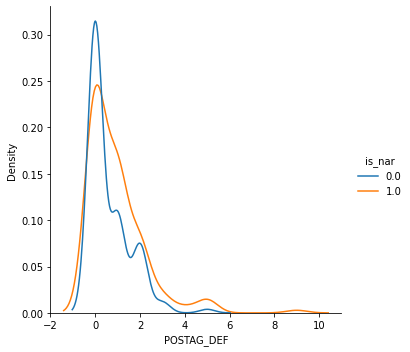

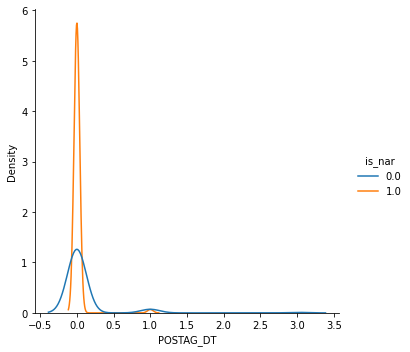

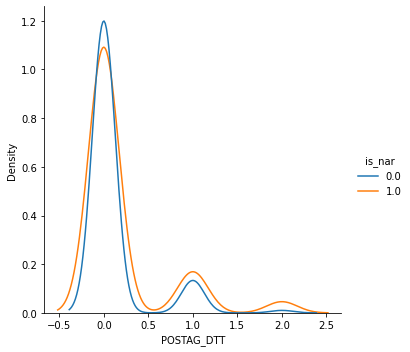

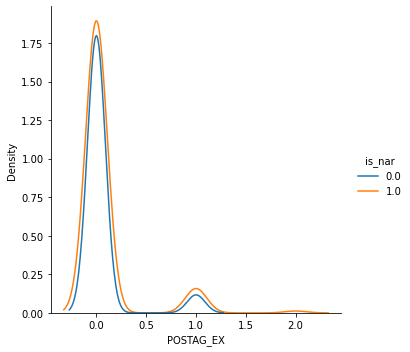

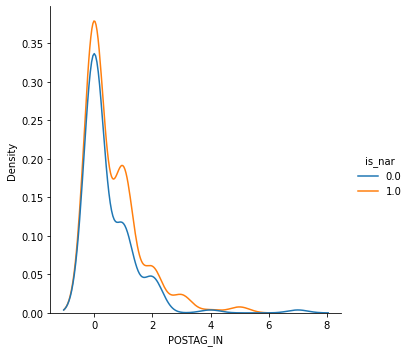

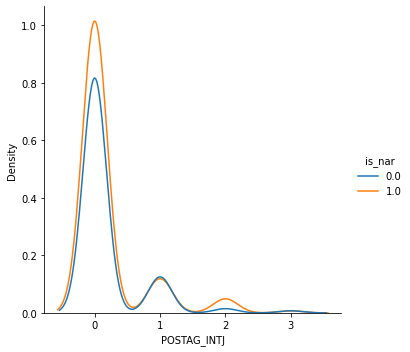

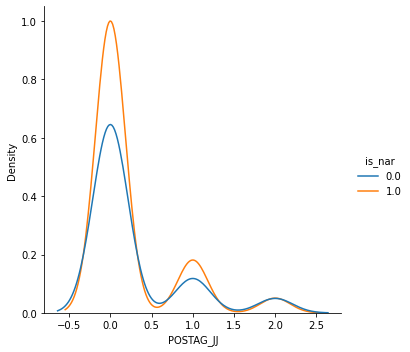

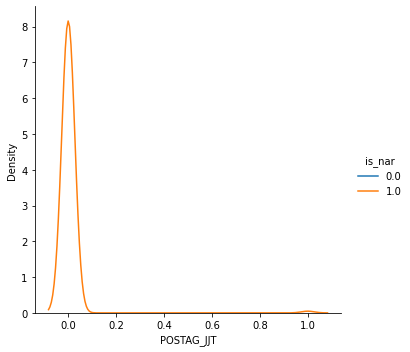

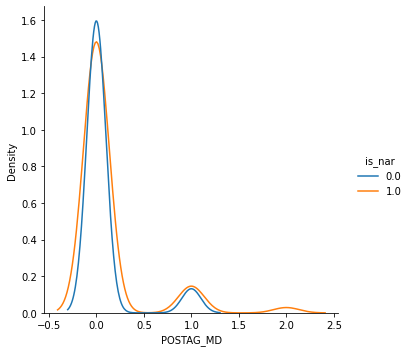

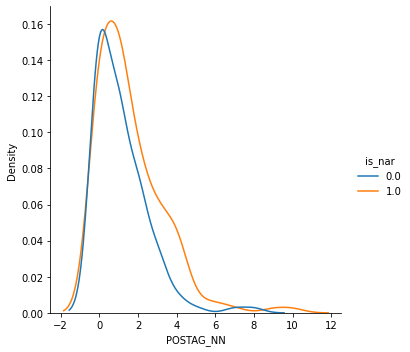

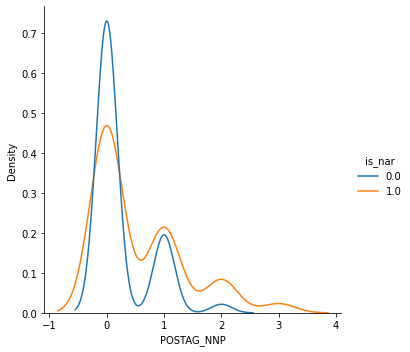

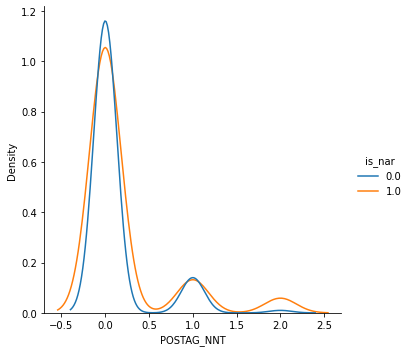

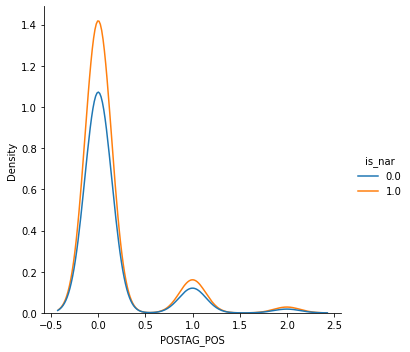

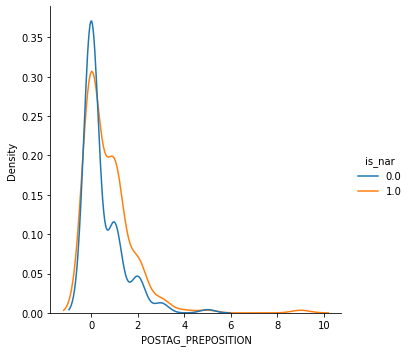

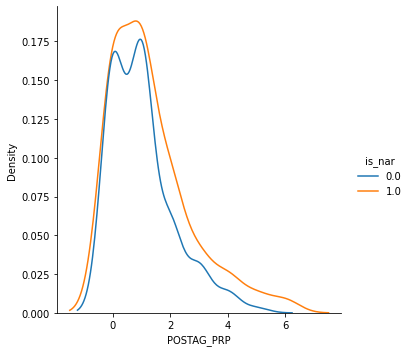

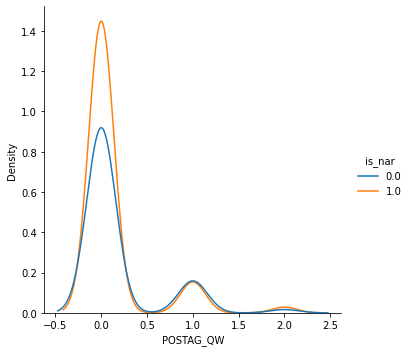

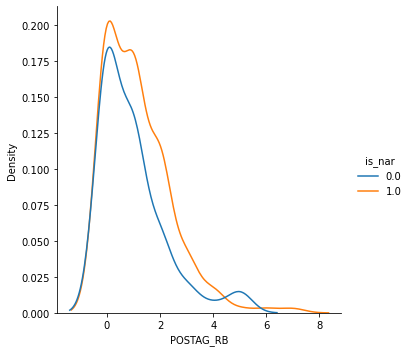

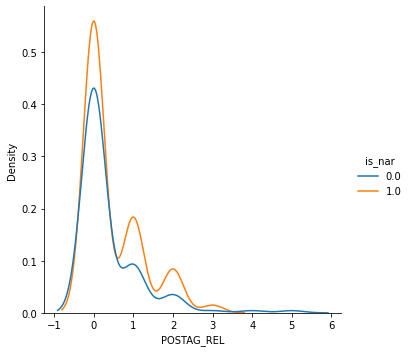

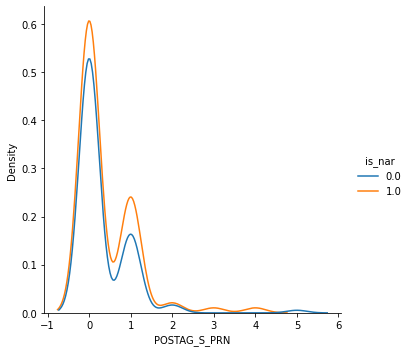

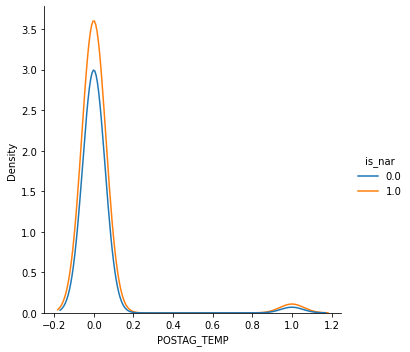

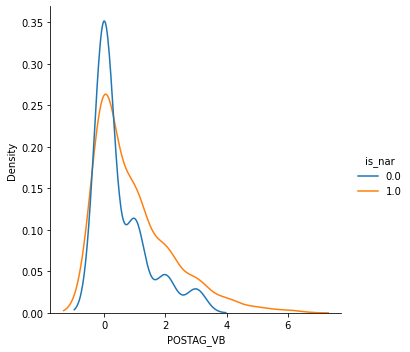

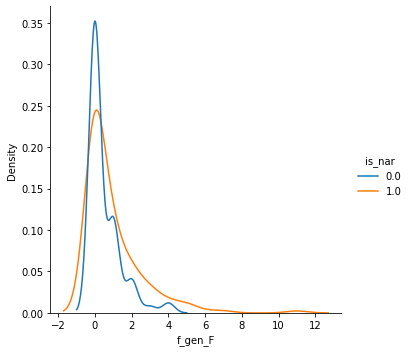

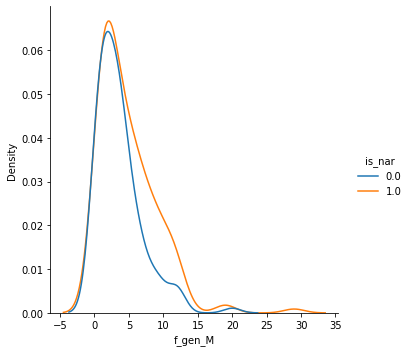

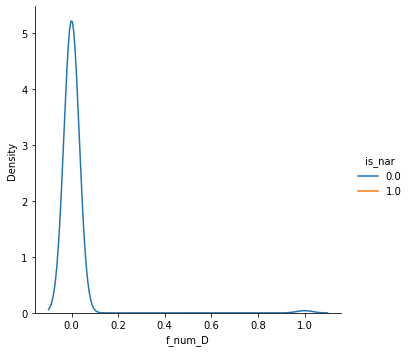

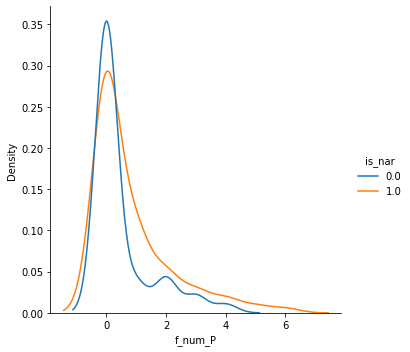

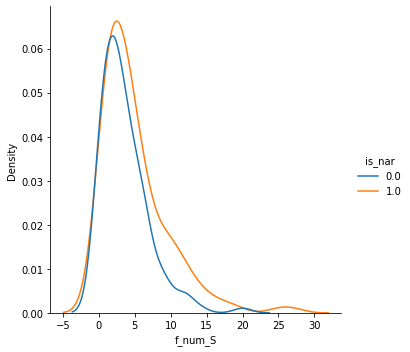

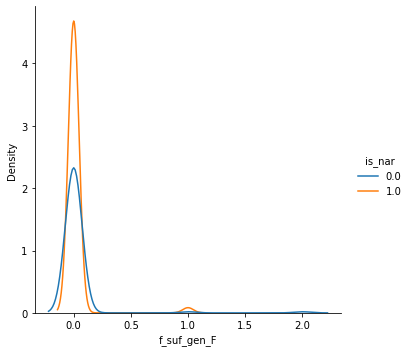

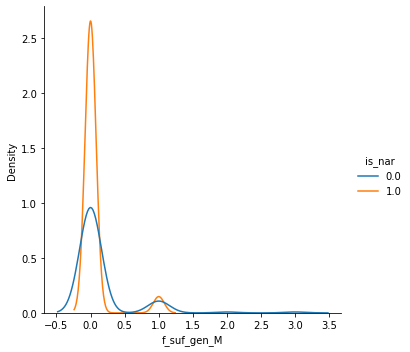

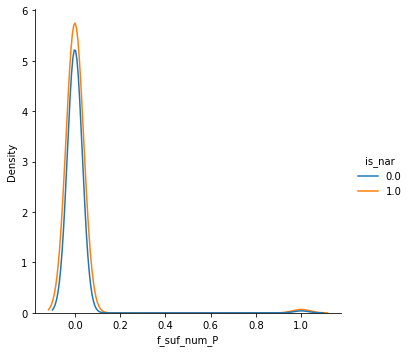

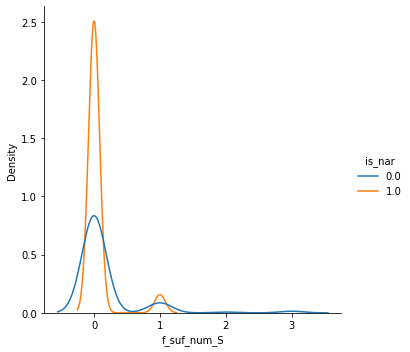

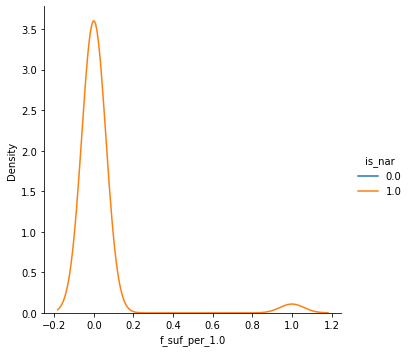

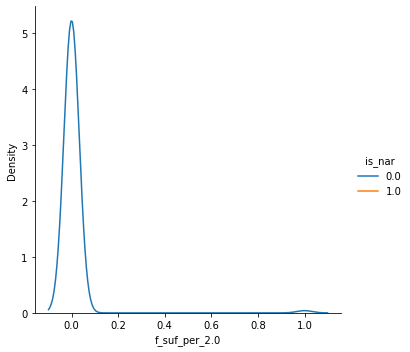

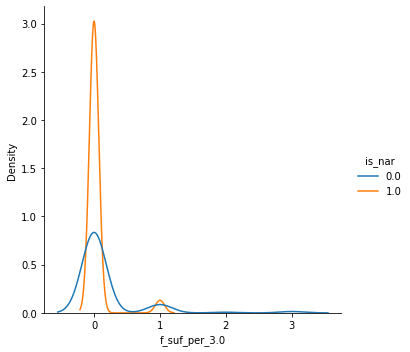

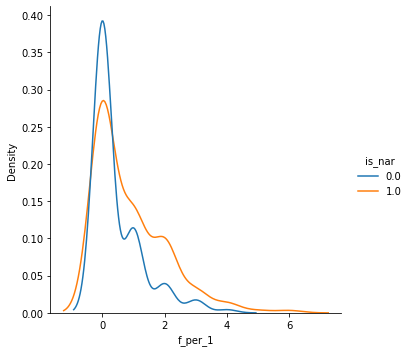

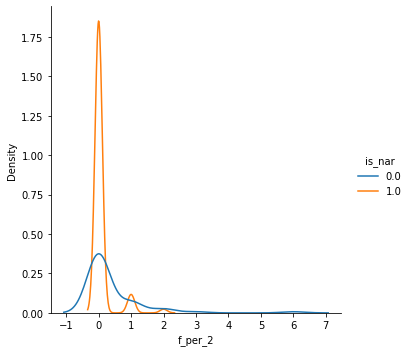

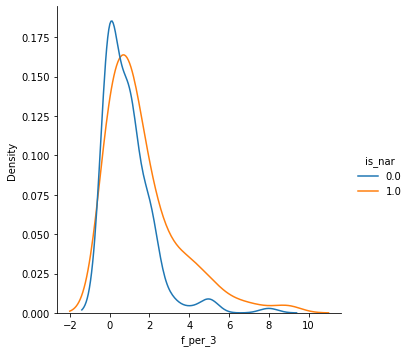

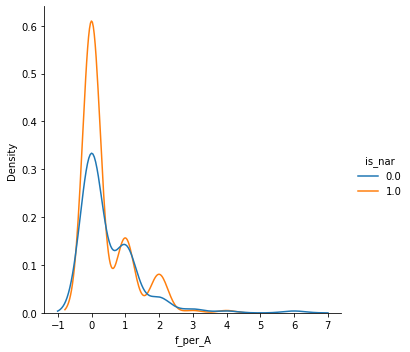

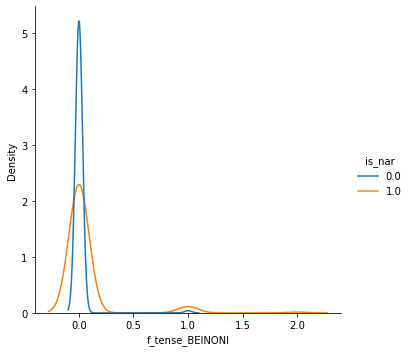

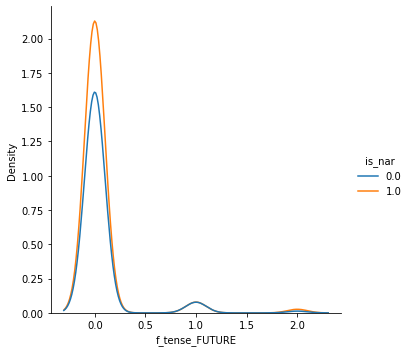

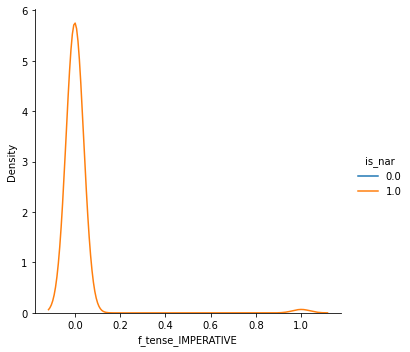

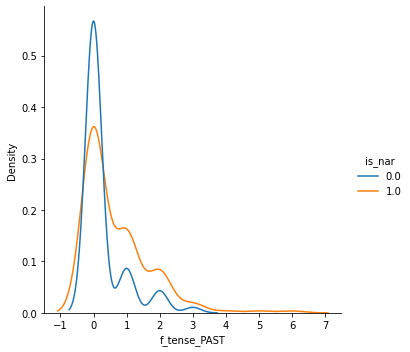

In [180]:
for i,col in enumerate(merged_sent_pos.columns[2:]):
    sns.displot(merged_sent_pos, x=col, hue="is_nar",kind='kde',warn_singular=False)

In [235]:
import scipy.stats as stats
nar = merged_sent_pos[merged_sent_pos['is_nar']==0]
not_nar = merged_sent_pos[merged_sent_pos['is_nar']==1]
def compare_distrib(col):
    u_res = stats.mannwhitneyu(nar[col],not_nar[col], alternative = 'two-sided')
    u_test_db.loc[col,'pvalue'] =  u_res.pvalue
    u_test_db.loc[col,'U'] = u_res.statistic 
    u_test_db.loc[col,'is_diff'] = u_res.pvalue < 0.05
#     if u_res.pvalue < 0.05 :#and u_res.statistic < 105):
#         print ('{} differ {}'.format(col,u_res.statistic))
#     else:
#         print('{} same {}'.format(col,u_res.statistic))# output
# MannwhitneyuResult(statistic=489.5, pvalue=7.004695394561267e-07)

In [236]:
u_test_db = pd.DataFrame(index=merged_sent_pos.columns[8:])

for i,col in enumerate(merged_sent_pos.columns[2:]):
    compare_distrib(col)
u_test_db[u_test_db['is_diff'] == True].sort_values(by=['pvalue'],ascending=True)

,pvalue,U,is_diff
is_nar,0.000000,0.000000,True
is_client,0.000000,7357.500000,True
f_tense_PAST,0.000039,8586.000000,True
f_per_2,0.000062,12939.000000,True
f_per_3,0.000164,8438.000000,True
POSTAG_NNP,0.000338,8916.500000,True
f_per_1,0.000409,8796.000000,True
sent_len,0.000821,8630.500000,True
POSTAG_VB,0.002187,9076.000000,True
f_num_P,0.005340,9397.000000,True


In [250]:
def sent2features(sent_idx,idx_in_seq):
    features = {}
    
    for col in merged_sent_pos.columns[3:]:
        features["{}".format(col)]=merged_sent_pos.loc[sent_idx,col]

    if idx_in_seq > 1:
        update = {}
        for col in merged_sent_pos.columns[3:]:
            update["-1:{}".format(col)]=merged_sent_pos.loc[sent_idx-1,col]
        features.update(update)
    else:
        features['BOS'] = True
    
    if idx_in_seq > 2:
        update = {}
        for col in merged_sent_pos.columns[3:]:
            update["-2:{}".format(col)]=merged_sent_pos.loc[sent_idx-2,col]
        features.update(update)

    if idx_in_seq < seq_len-1:
        update = {}
        for col in merged_sent_pos.columns[3:]:
            update["+1:{}".format(col)]=merged_sent_pos.loc[sent_idx+1,col]
        features.update(update)
    else:
        features['EOS'] = True

    return features

def sent2label(sent_idx):
    return "{}".format(merged_sent_pos.loc[sent_idx,'is_nar'].astype(bool))


In [255]:
seq_len = 6
def seq2features(first_sent_idx):
    return [sent2features(sent_idx,idx_in_seq) for idx_in_seq,sent_idx in enumerate(np.arange(first_sent_idx,first_sent_idx+seq_len,dtype=int))]
def seq2labels(first_sent_idx):
    return [sent2label(sent_idx) for sent_idx in range(first_sent_idx,first_sent_idx+seq_len)]

X = [seq2features(first_sent_idx) for first_sent_idx in merged_sent_pos.index[:-seq_len:seq_len]]
y = [seq2labels(first_sent_idx) for first_sent_idx in merged_sent_pos.index[:-seq_len:seq_len]]


In [258]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

In [263]:
from sklearn.model_selection import cross_validate

crf = CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True,
)
try:
    crf.fit(X_train, y_train)
except AttributeError:
    pass
predictions = crf.predict(X_test)

In [275]:
y_pred = predictions

In [276]:
labels = list(crf.classes_)
metrics.flat_f1_score(y_test, y_pred,
                      average='weighted', labels=labels)

0.7330779753761969

In [282]:
from collections import Counter

def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

print("Top likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(20))

print("\nTop unlikely transitions:")
print_transitions(Counter(crf.transition_features_).most_common()[-20:])

Top likely transitions:
False  -> False   1.758728
True   -> True    0.903944
True   -> False   -2.091328
False  -> True    -2.622403

Top unlikely transitions:
False  -> False   1.758728
True   -> True    0.903944
True   -> False   -2.091328
False  -> True    -2.622403


In [88]:
merged_raw =  pd.merge(sent_db[:300],sent_tokens_db,left_index=True,right_index=True,validate="one_to_one")
merged_raw

,is_nar,sent_len,first_sent_in_nar,last_sent_in_nar,is_client,FROM,sent_idx,TO,FORM,LEMMA,...,POSTAG,f_gen,f_num,FEATS,TOKEN,f_suf_gen,f_suf_num,f_suf_per,f_per,f_tense
0,0.000000,10.000000,False,False,0,0,0.000000,1,טוב,טוב,...,NNT,M,S,gen=M|num=S,1,NaN,NaN,NaN,NaN,NaN
1,0.000000,15.000000,False,False,1,1,0.000000,2,אהלן,אהלן,...,INTJ,NaN,NaN,_,2,NaN,NaN,NaN,NaN,NaN
2,0.000000,4.000000,False,False,0,2,0.000000,3,נ,נ,...,NNP,M,S,gen=F|gen=M|num=S,3,NaN,NaN,NaN,NaN,NaN
3,0.000000,8.000000,False,False,0,0,1.000000,1,היי,הי,...,INTJ,NaN,NaN,_,1,NaN,NaN,NaN,NaN,NaN
4,0.000000,73.000000,False,False,1,1,1.000000,2,מה,מה,...,QW,NaN,NaN,_,2,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0.000000,32.000000,False,False,0,11,24.000000,12,כאילו,כאילו,...,CC,NaN,NaN,_,9,NaN,NaN,NaN,NaN,NaN
296,0.000000,8.000000,False,False,0,12,24.000000,13,אנחנו,הוא,...,PRP,M,P,gen=F|gen=M|num=P|per=1,10,NaN,NaN,NaN,1,NaN
297,0.000000,34.000000,False,False,0,13,24.000000,14,כמה,כמה,...,DTT,NaN,NaN,_,11,NaN,NaN,NaN,NaN,NaN
298,0.000000,23.000000,False,False,0,14,24.000000,15,אנשים,איש,...,NN,M,P,gen=M|num=P,12,NaN,NaN,NaN,NaN,NaN


In [ ]:
def word2features(sent_idx):
    sent_len = sent_tokens_db[sent_tokens_db['sent_idx']==sent_idx]['TOKEN'].max()
    word_row = sent_tokens_db.query("sent_idx==  @sent_idx and TOKEN == @word_idx")

    features = {
#         'bias': 1.0,
        'word':word_row['LEMMA'].item(),
        'postag': word_row['POSTAG'].item(),
        'gen': word_row['f_suf_gen'].item(),
        'num': word_row['f_suf_num'].item(),
        'suf_per': word_row['f_suf_per'].item(),
        'per': word_row['f_per'].item(),
        'tense': word_row['f_tense'].item(),
    }
    if word_idx > 1:
        one_before_idx = word_idx-1
        word_row = sent_tokens_db.query("sent_idx==  @sent_idx and TOKEN == @one_before_idx")
        features.update({
            '-1:word':word_row['LEMMA'].item(),
        '-1:postag': word_row['POSTAG'].item(),
        '-1:gen': word_row['f_suf_gen'].item(),
        '-1:num':word_row['f_suf_num'].item(),
        '-1:suf_per': word_row['f_suf_per'].item(),
        '-1:per': word_row['f_per'].item(),
        '-1:tense': word_row['f_tense'].item(),
        })
    else:
        features['BOS'] = True
    
    if word_idx > 2:
        two_before_idx = word_idx-2
        word_row = sent_tokens_db.query("sent_idx==  @sent_idx and TOKEN == @two_before_idx")
        features.update({
            '-2:word':word_row['LEMMA'].item(),
        '-2:postag': word_row['POSTAG'].item(),
        '-2:gen':word_row['f_suf_gen'].item(),
        '-2:num':word_row['f_suf_num'].item(),
        '-2:suf_per': word_row['f_suf_per'].item(),
        '-2:per': word_row['f_per'].item(),
        '-2:tense': word_row['f_tense'].item(),
        })

    if word_idx < sent_len:
        one_after_idx = word_idx+1
        word_row =  sent_tokens_db.query("sent_idx==  @sent_idx and TOKEN == @one_after_idx")
        features.update({
            '+1:word':word_row['LEMMA'].item(),
        '+1:postag': word_row['POSTAG'].item(),
        '+1:gen': word_row['f_suf_gen'].item(),
        '+1:num': word_row['f_suf_num'].item(),
        '+1:suf_per': word_row['f_suf_per'].item(),
        '+1:per': word_row['f_per'].item(),
        '+1:tense': word_row['f_tense'].item(),
        })
    else:
        features['EOS'] = True

    return features

In [87]:
merged_count = pd.merge(sent_db[:300],sent_pos_db,left_index=True,right_index=True,validate="one_to_one")
merged_count

,is_nar,sent_len,first_sent_in_nar,last_sent_in_nar,is_client,POSTAG,f_gen,f_num,f_suf_gen,f_suf_num,f_suf_per,f_per,f_tense
0.000000,0.000000,10.000000,False,False,0,3,2,2,0,0,0,0,0
1.000000,0.000000,15.000000,False,False,1,4,1,1,0,0,0,0,0
2.000000,0.000000,4.000000,False,False,0,3,1,1,0,0,0,0,0
3.000000,0.000000,8.000000,False,False,0,3,1,1,1,1,1,0,0
4.000000,0.000000,73.000000,False,False,1,17,7,7,0,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
295.000000,0.000000,32.000000,False,False,0,9,6,6,0,0,0,4,0
296.000000,0.000000,8.000000,False,False,0,4,2,2,0,0,0,2,0
297.000000,0.000000,34.000000,False,False,0,12,5,5,0,0,0,3,1
298.000000,0.000000,23.000000,False,False,0,7,3,3,0,0,0,2,0


In [157]:
merged.describe()

,is_nar,sent_len,is_client,CPOSTAG,POSTAG,f_gen,f_num,f_suf_gen,f_suf_num,f_suf_per,f_per,f_tense
count,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000
mean,0.566667,35.273333,0.763333,10.436667,10.436667,5.043333,5.043333,0.110000,0.110000,0.110000,2.716667,0.616667
std,0.496364,31.243332,0.425746,9.328956,9.328956,4.611472,4.611472,0.380855,0.380855,0.380855,2.721718,0.982994
min,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,13.000000,1.000000,4.000000,4.000000,2.000000,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,1.000000,27.000000,1.000000,8.000000,8.000000,4.000000,4.000000,0.000000,0.000000,0.000000,2.000000,0.000000
75%,1.000000,50.000000,1.000000,14.000000,14.000000,7.000000,7.000000,0.000000,0.000000,0.000000,4.000000,1.000000
max,1.000000,187.000000,1.000000,62.000000,62.000000,30.000000,30.000000,3.000000,3.000000,3.000000,16.000000,6.000000


In [ ]:
sns.pairplot(hue="is_nar", data=merged)

<AxesSubplot:xlabel='is_nar', ylabel='count'>

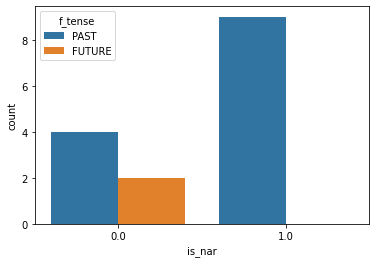

In [77]:
sns.countplot(x='is_nar',hue="f_tense", data=merged_raw)
# g = sns.catplot(x="class", hue="who", col="survived",
#                 data=titanic, kind="count",
#                 height=4, aspect=.7);

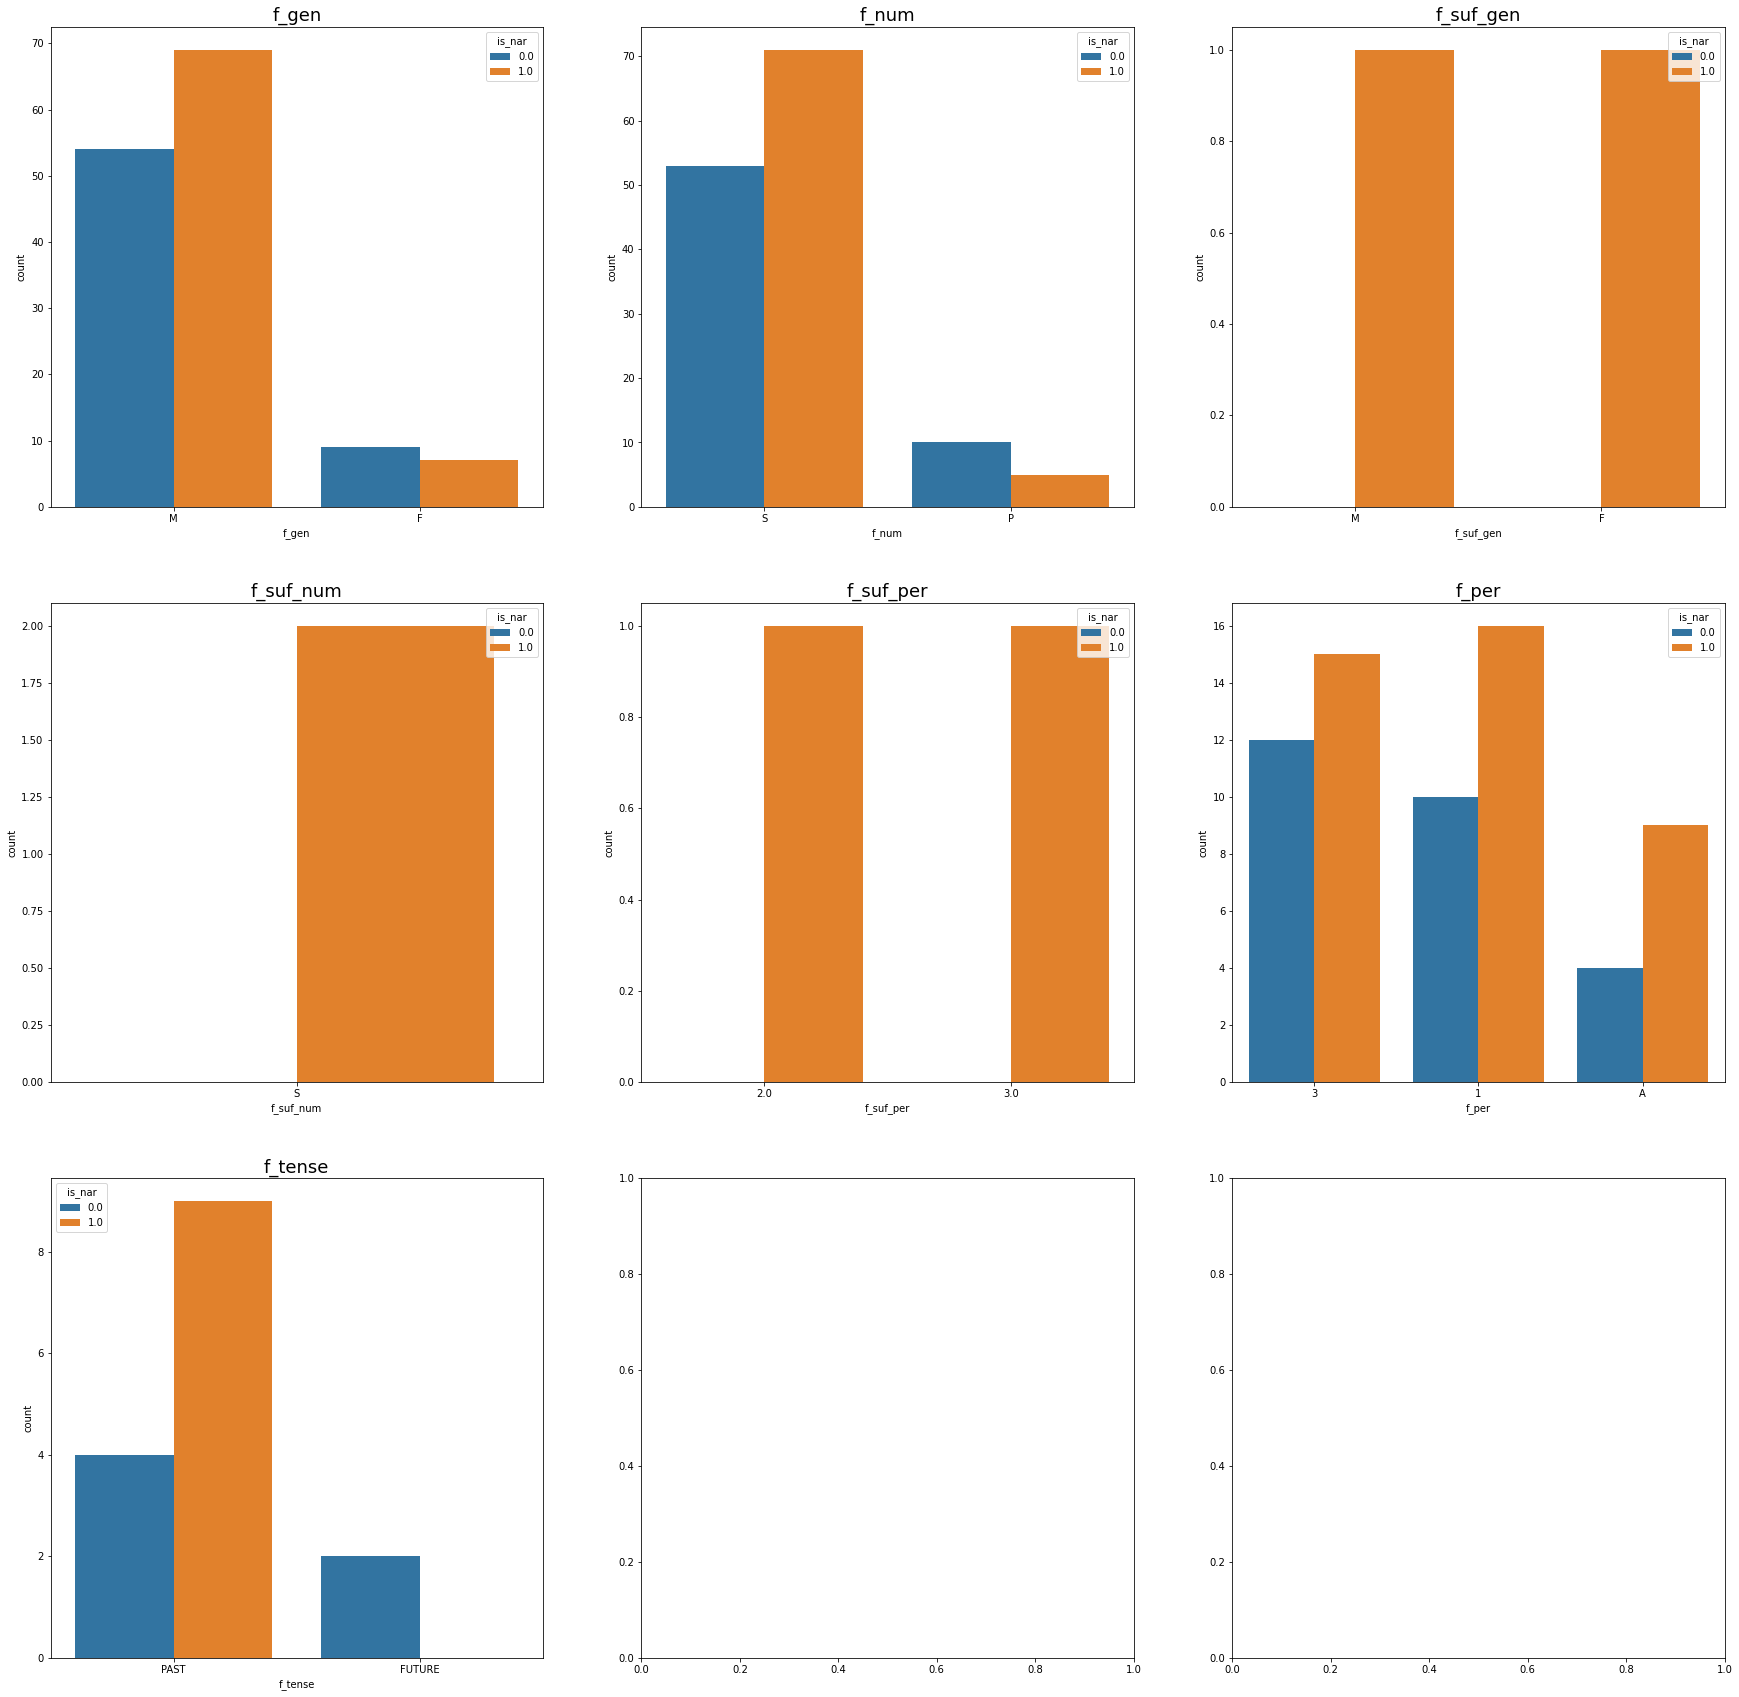

In [100]:
plot_num = len(columns_to_count)
fig, axes = plt.subplots(3, 3, figsize=(30,30))
for i,col in enumerate(columns_to_count[1:]):
    ax = axes.ravel()[i]
    sns.countplot(x=col,hue='is_nar', data=merged_raw,ax=ax)
#     df.boxplot('SalePrice',r2_scores[i,0], ax=ax) #TBD add weigths on X axis
    ax.set_title("{}".format(col), fontsize=18)

<AxesSubplot:xlabel='POSTAG'>

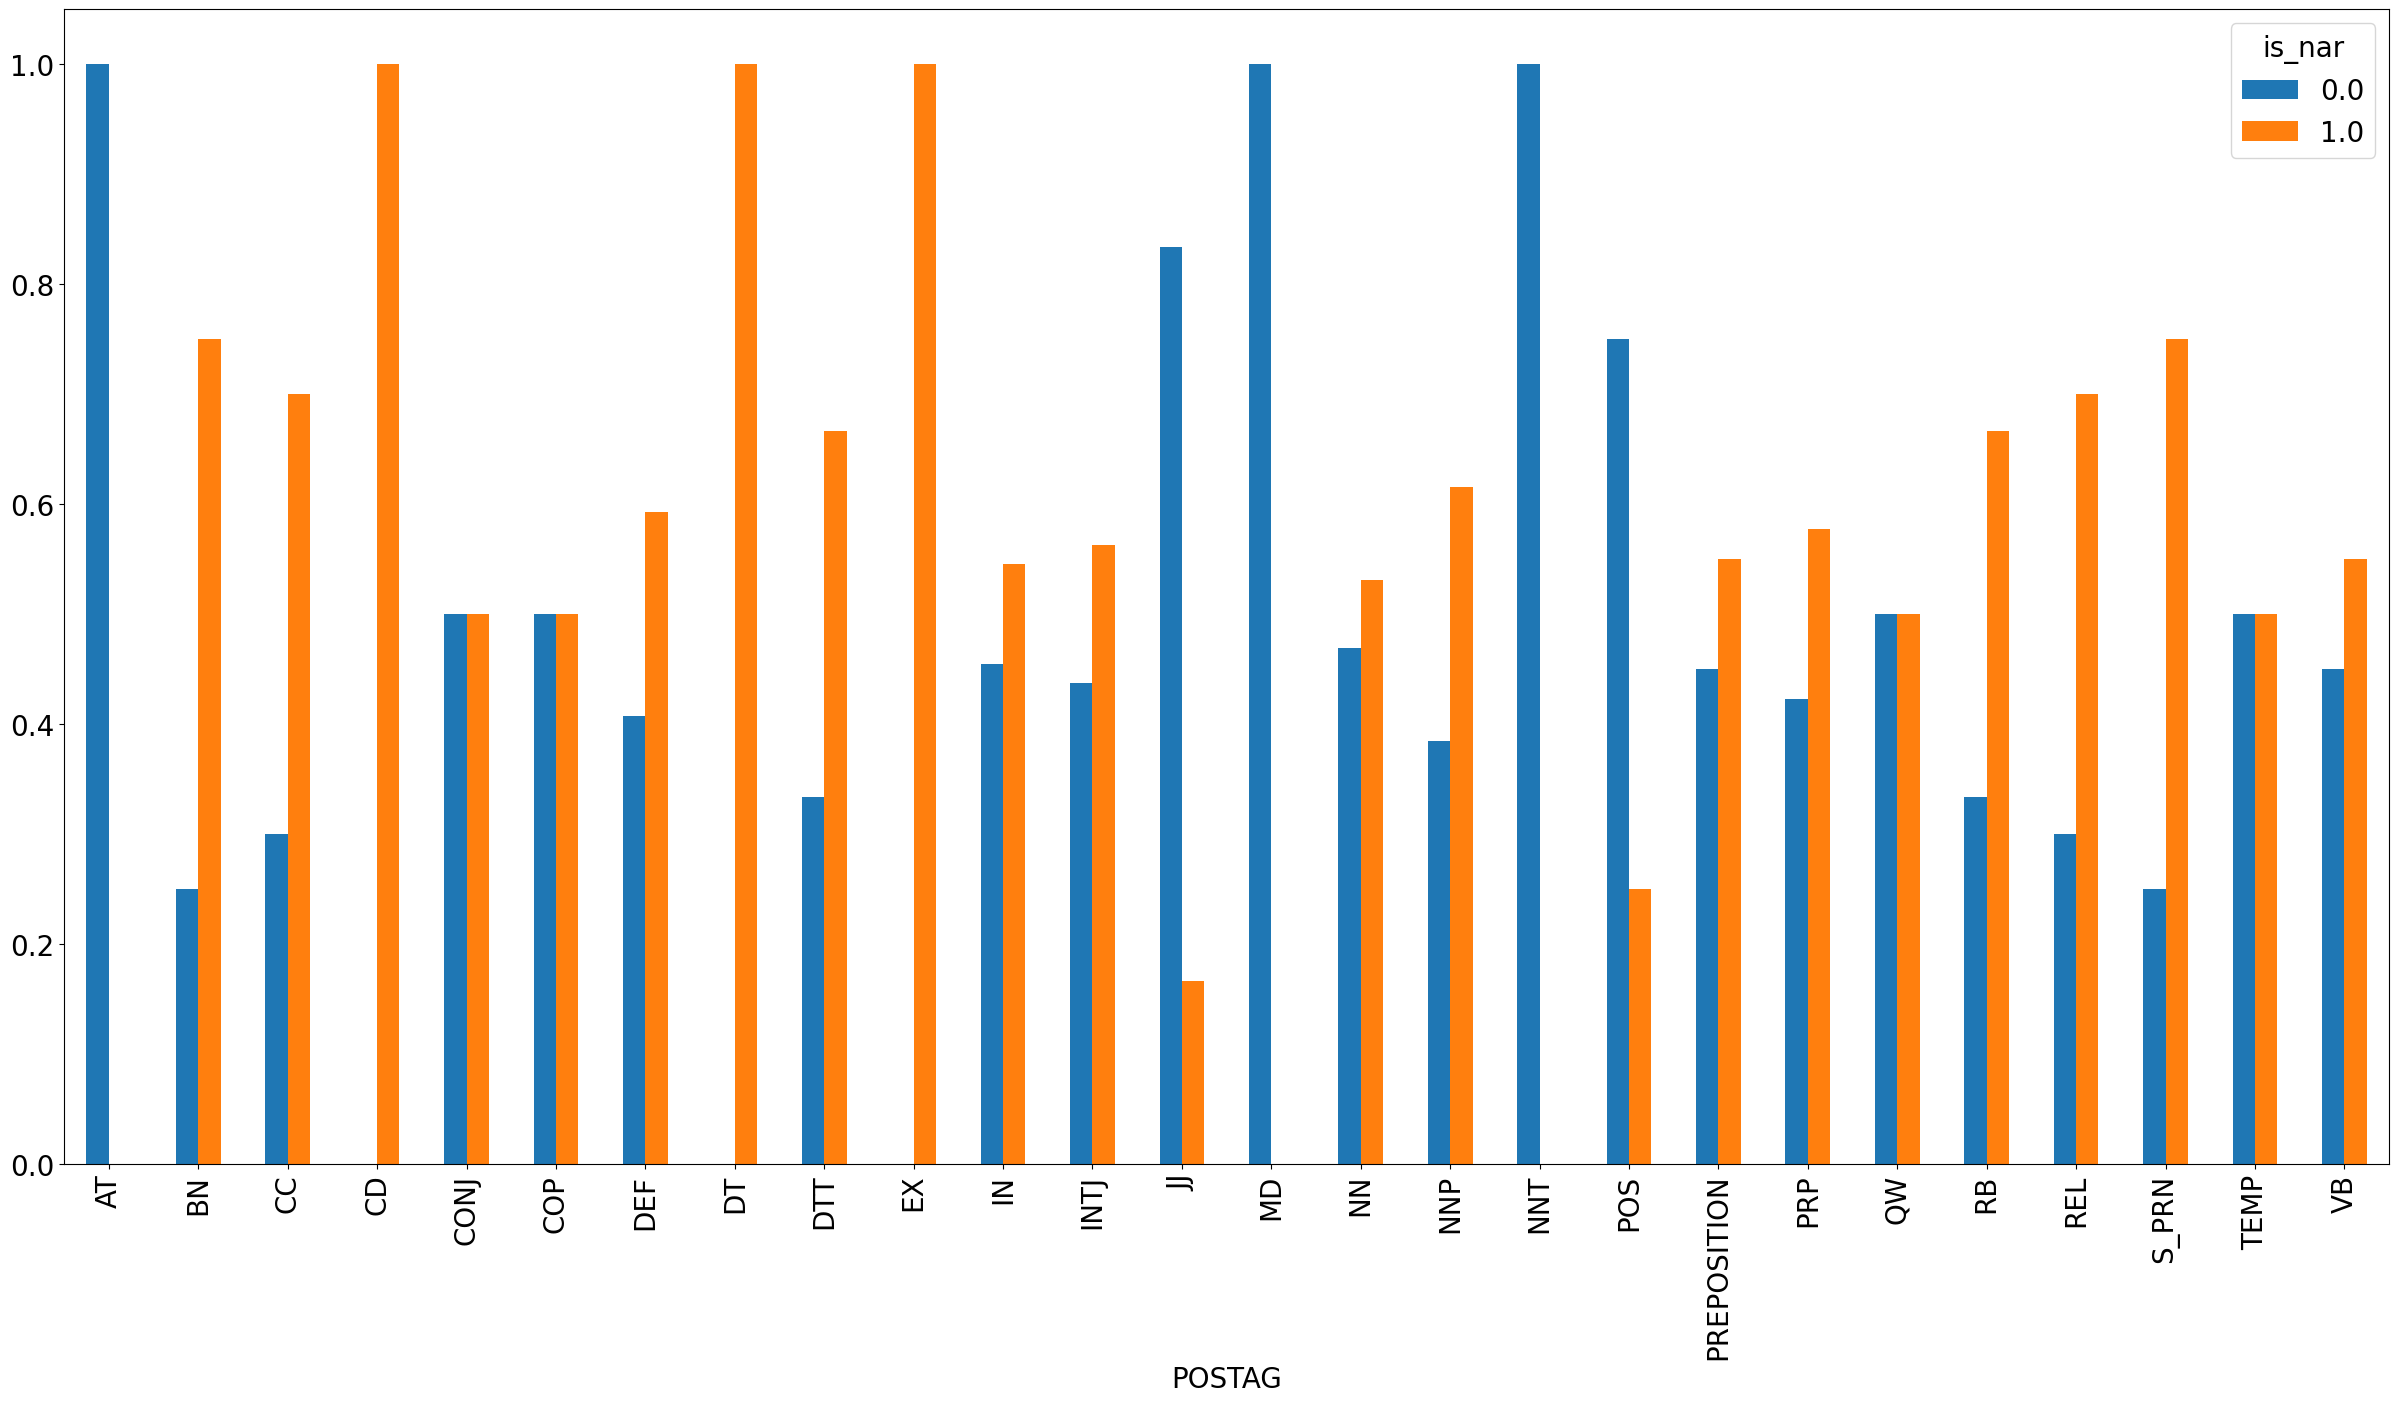

In [133]:
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(1, figsize=(30,15))
merged_raw.groupby([columns_to_count[0]])['is_nar'].value_counts(normalize=True).unstack().plot(kind='bar',ax=ax)

In [155]:
tags = merged_raw[columns_to_count[0]].unique()

In [156]:
imp.reload(defines)
imp.reload(feature_utils)
for tag in tags:
    print("{} : {}".format(tag,feature_utils.get_yap_tag_description(tag)))

NNT : Noun in construct state form
INTJ : Interjection
NNP : Proper noun
QW : WH words like when, where and how, which do not appear in a determiner position
DEF : Determiner
NN : NOUN
PREPOSITION : PREPOSITION
REL : The relativizers she, aher and ha (=that)
JJ : The construct state form of adjectives (like pitiless)
RB : Adverb
COP : Auxiliary verb = cop
CC : Coordinating conjunction
PRP : Personal pronoun
VB : A verb
IN : Preposition
DTT : definite article
TEMP : TEMP
CONJ : conjunction
BN : VERB-VerbForm=Part
EX :  VERB-HebExistential=True
DT : definite article
POS : Possessive item
S_PRN : Declarative sentence Parenthetical
AT : Accusative marker
CD : Numeral
MD : Modal


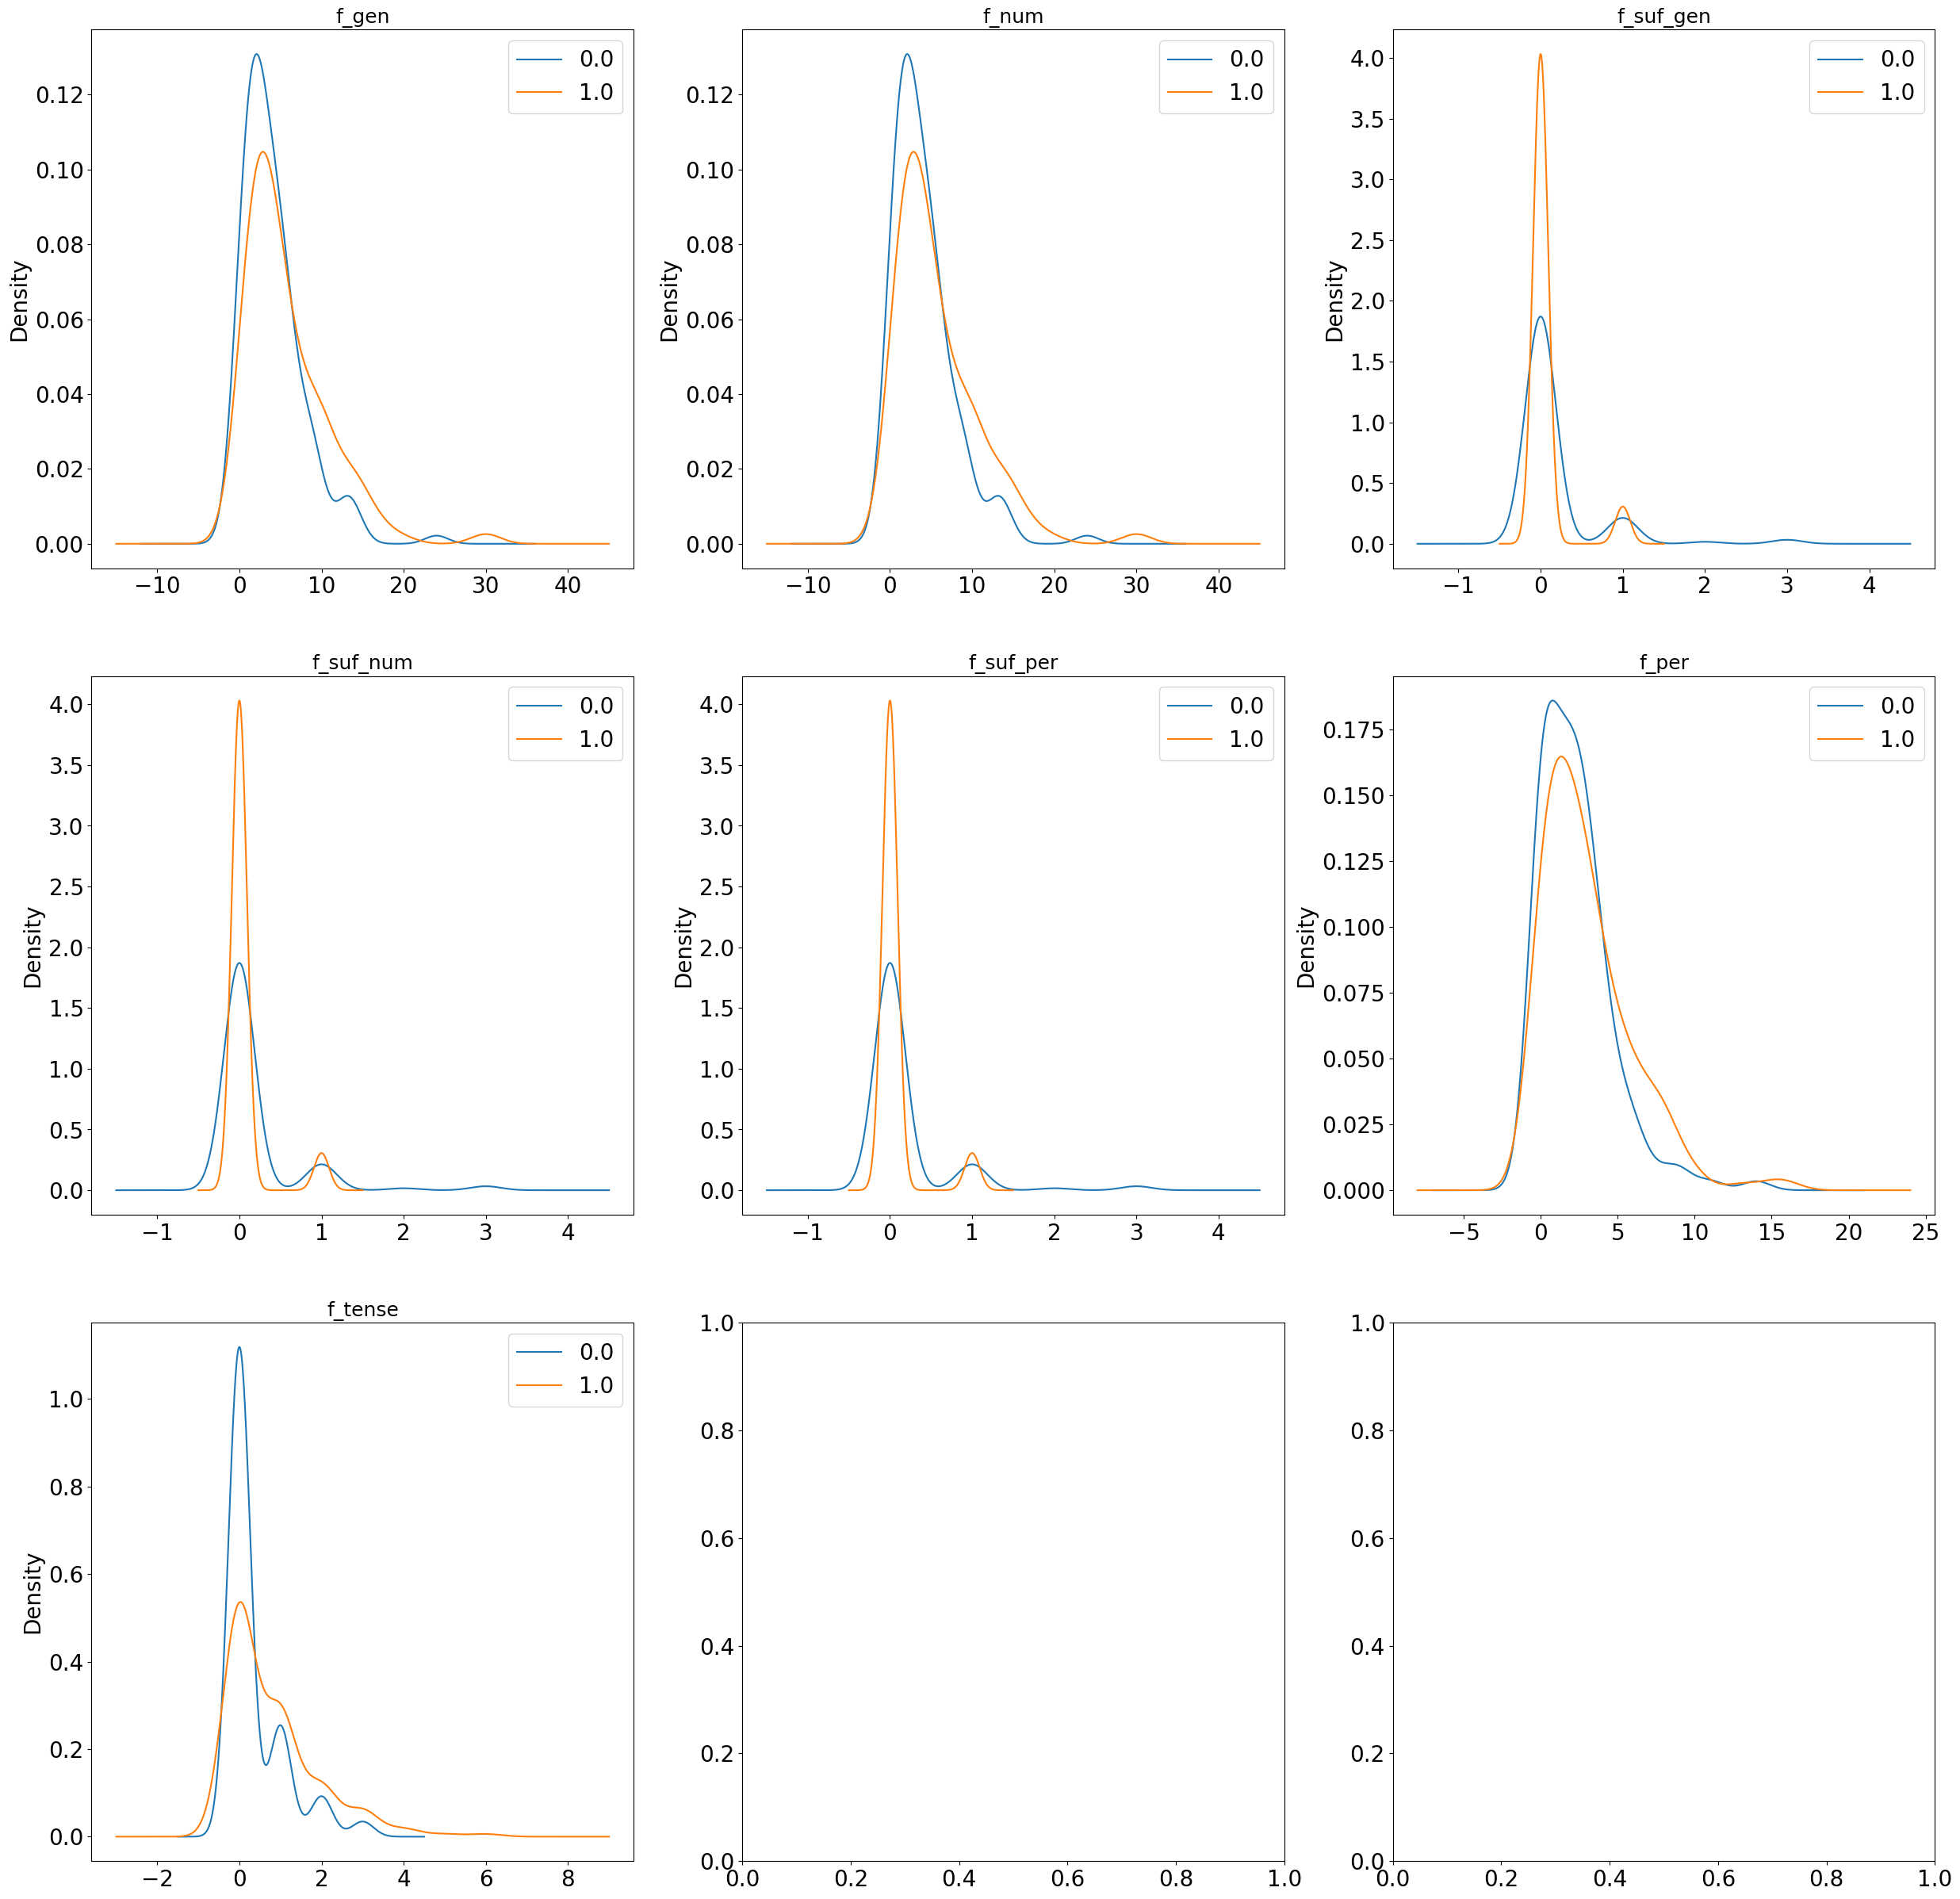

In [171]:
fig, axes = plt.subplots(3, 3, figsize=(30,30))
for i,col in enumerate(columns_to_count[1:]):
    ax = axes.ravel()[i]
    merged.groupby('is_nar')[col].plot(ax=ax,kind='kde',legend=True)#     df.boxplot('SalePrice',r2_scores[i,0], ax=ax) #TBD add weigths on X axis
    ax.set_title("{}".format(col), fontsize=18)
# merged.groupby('is_nar').plot(ax=ax,kind='kde',legend=True)

In [86]:
# Feature set
def word2features(sent_idx,word_idx):
    sent_len = sent_tokens_db[sent_tokens_db['sent_idx']==sent_idx]['TOKEN'].max()
    word_row = sent_tokens_db.query("sent_idx==  @sent_idx and TOKEN == @word_idx")

    features = {
#         'bias': 1.0,
        'word':word_row['LEMMA'].item(),
        'postag': word_row['POSTAG'].item(),
        'gen': word_row['f_suf_gen'].item(),
        'num': word_row['f_suf_num'].item(),
        'suf_per': word_row['f_suf_per'].item(),
        'per': word_row['f_per'].item(),
        'tense': word_row['f_tense'].item(),
    }
    if word_idx > 1:
        one_before_idx = word_idx-1
        word_row = sent_tokens_db.query("sent_idx==  @sent_idx and TOKEN == @one_before_idx")
        features.update({
            '-1:word':word_row['LEMMA'].item(),
        '-1:postag': word_row['POSTAG'].item(),
        '-1:gen': word_row['f_suf_gen'].item(),
        '-1:num':word_row['f_suf_num'].item(),
        '-1:suf_per': word_row['f_suf_per'].item(),
        '-1:per': word_row['f_per'].item(),
        '-1:tense': word_row['f_tense'].item(),
        })
    else:
        features['BOS'] = True
    
    if word_idx > 2:
        two_before_idx = word_idx-2
        word_row = sent_tokens_db.query("sent_idx==  @sent_idx and TOKEN == @two_before_idx")
        features.update({
            '-2:word':word_row['LEMMA'].item(),
        '-2:postag': word_row['POSTAG'].item(),
        '-2:gen':word_row['f_suf_gen'].item(),
        '-2:num':word_row['f_suf_num'].item(),
        '-2:suf_per': word_row['f_suf_per'].item(),
        '-2:per': word_row['f_per'].item(),
        '-2:tense': word_row['f_tense'].item(),
        })

    if word_idx < sent_len:
        one_after_idx = word_idx+1
        word_row =  sent_tokens_db.query("sent_idx==  @sent_idx and TOKEN == @one_after_idx")
        features.update({
            '+1:word':word_row['LEMMA'].item(),
        '+1:postag': word_row['POSTAG'].item(),
        '+1:gen': word_row['f_suf_gen'].item(),
        '+1:num': word_row['f_suf_num'].item(),
        '+1:suf_per': word_row['f_suf_per'].item(),
        '+1:per': word_row['f_per'].item(),
        '+1:tense': word_row['f_tense'].item(),
        })
    else:
        features['EOS'] = True

    return features

def sent2features(sent_idx):
    return [word2features(sent_idx,word_idx) for word_idx in sent_tokens_db[sent_tokens_db['sent_idx']==sent_idx]['TOKEN']]


# def sent2labels(sent):
#     return [sent_tokens_db.iloc[word,'is_nar'] for word in sent_tokens_db.index]
#Creating the train and test set
X = [sent2features(sent_idx) for sent_idx in sent_tokens_db['sent_idx'].unique()[:1]]
# y = [sent2labels(s) for s in sentences]
# X = [sent2features(1)]

In [87]:
X

[[{'word': 'טוב',
   'postag': 'NNT',
   'gen': nan,
   'num': nan,
   'suf_per': nan,
   'per': nan,
   'tense': nan,
   'BOS': True,
   '+1:word': 'אהלן',
   '+1:postag': 'INTJ',
   '+1:gen': nan,
   '+1:num': nan,
   '+1:suf_per': nan,
   '+1:per': nan,
   '+1:tense': nan},
  {'word': 'אהלן',
   'postag': 'INTJ',
   'gen': nan,
   'num': nan,
   'suf_per': nan,
   'per': nan,
   'tense': nan,
   '-1:word': 'טוב',
   '-1:postag': 'NNT',
   '-1:gen': nan,
   '-1:num': nan,
   '-1:suf_per': nan,
   '-1:per': nan,
   '-1:tense': nan,
   '+1:word': 'נ',
   '+1:postag': 'NNP',
   '+1:gen': nan,
   '+1:num': nan,
   '+1:suf_per': nan,
   '+1:per': nan,
   '+1:tense': nan},
  {'word': 'נ',
   'postag': 'NNP',
   'gen': nan,
   'num': nan,
   'suf_per': nan,
   'per': nan,
   'tense': nan,
   '-1:word': 'אהלן',
   '-1:postag': 'INTJ',
   '-1:gen': nan,
   '-1:num': nan,
   '-1:suf_per': nan,
   '-1:per': nan,
   '-1:tense': nan,
   '-2:word': 'טוב',
   '-2:postag': 'NNT',
   '-2:gen': nan,
 

In [193]:
def seq2features(seq_idx):
    seq = []
    for s in range(seq_idx,seq_idx+seq_len):
         seq.extend(sent2features(s))
    return seq

def seq2labels(seq_idx):
    seq = []
    for s in range(seq_idx,seq_idx+seq_len):
        label = sent2labels(s)
        seq.extend([label for i in range(vec_dim)]) # 2 - for 2 more featues EOS and BOS
    return seq

In [195]:
X[0], y[0]

(['v0',
  'v1',
  'v2',
  'v3',
  'v4',
  'v5',
  'v6',
  'v7',
  'v8',
  'v9',
  'v10',
  'v11',
  'v12',
  'v13',
  'v14',
  'v15',
  'v16',
  'v17',
  'v18',
  'v19',
  'v20',
  'v21',
  'v22',
  'v23',
  'v24',
  'v25',
  'v26',
  'v27',
  'v28',
  'v29',
  'v30',
  'v31',
  'v32',
  'v33',
  'v34',
  'v35',
  'v36',
  'v37',
  'v38',
  'v39',
  'v40',
  'v41',
  'v42',
  'v43',
  'v44',
  'v45',
  'v46',
  'v47',
  'v48',
  'v49',
  'v50',
  'v51',
  'v52',
  'v53',
  'v54',
  'v55',
  'v56',
  'v57',
  'v58',
  'v59',
  'v60',
  'v61',
  'v62',
  'v63',
  'v64',
  'v65',
  'v66',
  'v67',
  'v68',
  'v69',
  'v70',
  'v71',
  'v72',
  'v73',
  'v74',
  'v75',
  'v76',
  'v77',
  'v78',
  'v79',
  'v80',
  'v81',
  'v82',
  'v83',
  'v84',
  'v85',
  'v86',
  'v87',
  'v88',
  'v89',
  'v90',
  'v91',
  'v92',
  'v93',
  'v94',
  'v95',
  'v96',
  'v97',
  'v98',
  'v99',
  'BOS',
  'v0',
  'v1',
  'v2',
  'v3',
  'v4',
  'v5',
  'v6',
  'v7',
  'v8',
  'v9',
  'v10',
  'v11',
  '

In [196]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

In [197]:
len(X_train), len(y_train), len(X_test), len(y_test)

(469, 469, 231, 231)

In [198]:
# from sklearn.metrics import make_scorer
# from sklearn_crfsuite import metrics
# f1_scorer = make_scorer(metrics.flat_f1_score, average='macro') 
from sklearn.model_selection import cross_validate

crf = CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
#     all_possible_transitions=True,
)
try:
    crf.fit(X_train, y_train)
except AttributeError:
    pass
predictions = crf.predict(X_test)
# pred = cross_val_predict(estimator=crf, X=X_train, y=y_train, cv=5)
# scores = cross_validate(crf, X, y, scoring="f1_macro", cv=5)
# print(scores.test_score)

ValueError: The numbers of items and labels differ: |x| = 402, |y| = 408

In [171]:
predictions
# feature_utils.get_prediction_report(y_test,predictions)

[['v0',
  'v1',
  'v2',
  'v3',
  'v4',
  'v5',
  'v6',
  'v7',
  'v8',
  'v9',
  'v10',
  'v11',
  'v12',
  'v13',
  'v14',
  'v15',
  'v16',
  'v17',
  'v18',
  'v19',
  'v20',
  'v21',
  'v22',
  'v23',
  'v24',
  'v25',
  'v26',
  'v27',
  'v28',
  'v29',
  'v30',
  'v31',
  'v32',
  'v33',
  'v34',
  'v35',
  'v36',
  'v37',
  'v38',
  'v39',
  'v40',
  'v41',
  'v42',
  'v43',
  'v44',
  'v45',
  'v46',
  'v47',
  'v48',
  'v49',
  'v50',
  'v51',
  'v52',
  'v53',
  'v54',
  'v55',
  'v56',
  'v57',
  'v58',
  'v59',
  'v60',
  'v61',
  'v62',
  'v63',
  'v64',
  'v65',
  'v66',
  'v67',
  'v68',
  'v69',
  'v70',
  'v71',
  'v72',
  'v73',
  'v74',
  'v75',
  'v76',
  'v77',
  'v78',
  'v79',
  'v80',
  'v81',
  'v82',
  'v83',
  'v84',
  'v85',
  'v86',
  'v87',
  'v88',
  'v89',
  'v90',
  'v91',
  'v92',
  'v93',
  'v94',
  'v95',
  'v96',
  'v97',
  'v98',
  'v99',
  'BOS',
  'v0',
  'v1',
  'v2',
  'v3',
  'v4',
  'v5',
  'v6',
  'v7',
  'v8',
  'v9',
  'v10',
  'v11',
  '

In [51]:
sent_vec_db

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,is_nar,sent_len
0,-0.114521,0.000108,0.036471,-0.024207,0.002051,0.014730,-0.104159,0.058651,0.005404,0.056529,...,-0.002414,0.039244,-0.094238,0.025045,0.097398,-0.004409,0.041561,-0.049388,0.0,9.0
1,-0.013333,0.000648,0.013545,-0.001843,0.037912,0.044653,-0.033737,0.020353,-0.039255,0.040033,...,0.038335,0.013976,-0.062025,-0.025751,-0.032749,0.038144,-0.012054,0.083821,0.0,7.0
2,-0.049959,0.006207,0.019215,-0.013564,-0.006140,-0.020194,-0.021590,0.033078,0.043775,0.076063,...,-0.021449,-0.031051,-0.009857,0.012590,0.040845,-0.031004,0.001470,-0.049673,0.0,6.0
3,-0.009683,0.047087,0.037459,0.019149,0.005652,-0.042241,0.013978,0.052192,-0.023080,0.002327,...,-0.029806,0.033418,-0.029150,0.014673,0.022372,0.058281,0.031803,-0.026994,0.0,18.0
4,0.060957,0.005640,-0.018319,-0.002478,0.010457,-0.024910,0.091064,0.000475,0.066396,-0.038925,...,-0.024806,-0.046600,-0.026737,-0.015007,0.005086,0.030338,0.038523,-0.014919,0.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2834,0.044579,0.024742,0.028893,-0.060388,0.039829,0.025243,-0.117620,-0.028324,0.013425,-0.002992,...,-0.027126,-0.003454,-0.037883,0.018410,0.046375,0.052125,-0.023152,0.060160,0.0,3.0
2835,0.017902,0.038459,-0.016246,-0.003681,-0.026354,0.042227,0.019360,0.023875,-0.001420,0.015527,...,-0.022408,0.012324,-0.014626,0.004259,0.006237,0.035307,0.027554,-0.016158,0.0,30.0
2836,0.013650,0.023375,0.017228,0.000760,0.006687,0.010800,-0.005754,0.013923,0.009729,0.018878,...,-0.015082,0.006376,-0.010457,0.021521,-0.011850,0.022129,0.016181,0.004594,0.0,37.0
2837,0.009727,0.017978,0.027529,0.006578,0.020192,-0.020603,0.027635,0.017854,0.040842,0.017801,...,-0.019581,-0.002811,-0.012890,0.033547,0.007128,-0.002388,0.006980,-0.007728,0.0,23.0
